# Week 3. Example Solutions

This notebook shows example solutions with **k-Nearest Neighbours** and **k-Means Clustering** in application to the Aleph B-Jet data set. Note, k-MC may not be well-suited for this data set; however, we will learn new useful dimensionality reduction and feature ranking methods that could be used here in Week 3 & 4.

***
* Author: Vadim Rusakov
* Email:  vadim.rusakov@nbi.ku.dk
* Date:   12th of May 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
datafile = "../Week1/AlephBtag_MC_small_v2.csv"
datatable = pd.read_csv(datafile, sep='\s+', dtype=np.float32)
y_aleph, y = datatable['nnbjet'], datatable['isb']
X = datatable.drop(labels=['nnbjet', 'isb'], axis=1)
X

,energy,cTheta,phi,prob_b,spheri,pt2rel,multip,bqvjet,ptlrel
0,46.829899,0.3871,0.8528,0.0327,0.2105,0.0302,0.4776,0.0314,-0.0003
1,45.639702,-0.3943,-2.2817,0.0035,0.3457,0.0314,0.3497,0.0106,-0.0003
2,48.896000,-0.4613,-0.6139,0.0649,0.0872,0.0254,0.1288,0.1074,-0.0003
3,39.157700,0.4668,2.4818,0.0027,0.1570,0.0147,0.2732,0.2117,0.0240
4,43.735401,-0.7642,1.7872,0.4320,0.4873,0.0505,0.3536,0.4578,-0.0003
...,...,...,...,...,...,...,...,...,...
33963,48.645802,-0.2944,3.0779,0.0273,0.2619,0.0370,0.4729,0.0203,-0.0003
33964,53.095299,-0.6435,-0.3996,0.0153,0.1120,0.0738,0.2943,0.0767,-0.0003
33965,46.222599,0.6304,2.7350,0.1191,0.2643,0.0192,0.0436,0.0301,-0.0003
33966,45.444401,0.0718,-2.0928,0.1928,0.7044,0.1263,0.6126,0.6859,-0.0003


Just for knowing our data set, note that the Aleph data set is unbalanced, with a higher fraction of background events (rather than signal events).

In [3]:
print(f"There are {y[y==0].shape[0]} non-bjet and {y[y==1].shape[0]} bjet events.")

There are 26308 non-bjet and 7660 bjet events.


Prepare out data sets (train, val, test). Aleph data set contains 30k+ data points, which could be better (especially when you have many features), but not bad. If we had less data, we would want to use cross-validation for a more efficient data usage. But now we are going to proceed with having our data sets in the following proportions:

`Train : validation : test = 60 : 20 : 20`

Finally, remember to transform the variables to the same range!

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# test set size = 20%
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=42)
# train / val set sizes = 60% / 20%
X_train_, X_val_, y_train, y_val = train_test_split(X_train_, y_train, test_size=0.25, 
                                                    shuffle=True, random_state=42)

# transform all features to the range (0, 1), based on trainig data
#transform = MinMaxScaler(feature_range=(0, 1))
transform = QuantileTransformer(output_distribution='uniform')
X_train = transform.fit_transform(X_train_)
X_val = transform.transform(X_val_)
X_test = transform.transform(X_test_)

Also, for the sake of having consistent data sets in terms of fractions of events, we can do a quick check:

In [5]:
len(y_train[y_train == 0]) / len(y_train), len(y_val[y_val == 0]) / len(y_val),\
len(y_test[y_test == 0]) / len(y_test), len(y[y == 0]) / len(y)

(0.773405299313052, 0.7793641448336768, 0.772887842213718, 0.7744936410739519)

Our training data may be good enough, but remember the **curse of dimensionality**? Distances between points are crucial for k-NN, so is it enough to have 30k+ data points to properly sample the 9-dimensional ball? As the next step we can try reducing the dimensionality (try the exercise both with and without this step).

In [6]:
from sklearn.decomposition import KernelPCA

# apply Kernal PCA based on training data
# can set 'njobs=-1' to use all cpu processes
kpca = KernelPCA(n_components=2, kernel='rbf', n_jobs=-1)
X_train_kpca = kpca.fit_transform(X_train)
X_val_kpca = kpca.transform(X_val)
X_test_kpca = kpca.transform(X_test)

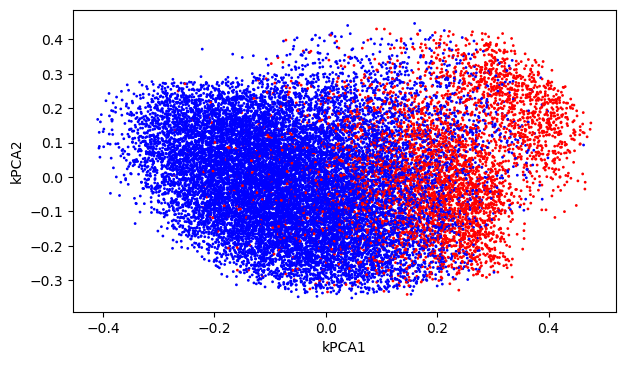

In [7]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'kPCA1', 
                                   'ylabel': 'kPCA2'})
plt.scatter(X_train_kpca[:,0], X_train_kpca[:,1], s=1, 
            c=y_train, cmap='bwr')
plt.show()

# k-Nearest Neighbours

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# kNN with inverse distance weights
knn_clf = KNeighborsClassifier(n_neighbors=51, n_jobs=-1, 
                               weights='distance')
knn_clf.fit(X_train_kpca, y_train)
y_pred = knn_clf.predict(X_train_kpca)

print(f"Train accuracy: {accuracy_score(y_train, y_pred):.3f}")

Train accuracy: 1.000


The prediction accuracy on the training data is ("of course") not too bad, but, remember, that we have to test our methods on a separate data set (test set) and not the training one.

But before testing, let's find an optimal choice of two parameters for our k-NN algorithm: different $k$ numbers and two different metrics with our data. We will use here `manhattan` (L1-norm) and `euclidean` (L2-norm) distance metrics. 

On every loop iteration we use our training set as the basis for voting and we validate each configuration on the validation set. 

(`NOTE`: this may run for a couple of minutes; to reduce the time, decrease number of `ks`)

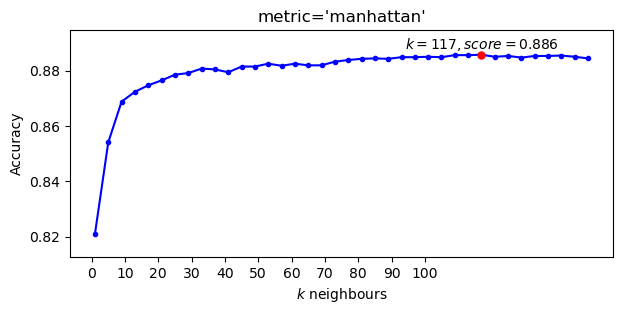

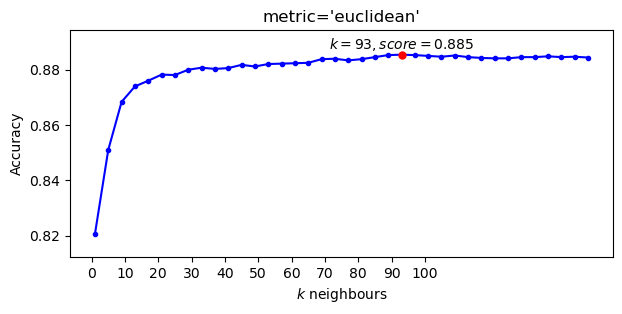

In [9]:
# loop over different k values
metrics = ['manhattan', 'euclidean']
ks = np.arange(1, 151, 4) # iterate over odd numbers (for voting purposes)
scores = {}
for metric in metrics:
    scores[metric] = np.empty(shape=ks.shape)
    for i, k in enumerate(ks):
        knn_clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, 
                                       weights='distance', 
                                       metric=metric)
        knn_clf.fit(X_train_kpca, y_train) # store training set
        y_pred = knn_clf.predict(X_val_kpca) # classify validation set
        scores[metric][i] = (accuracy_score(y_val, y_pred))

    # plot the accuracy scores
    scores_ = scores[metric]
    kbest = ks[scores_==scores_.max()].item(0)
    scbest = scores_[scores_==scores_.max()].item(0)
    fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                           subplot_kw={'xlabel': '$k$ neighbours', 
                                       'ylabel': 'Accuracy',
                                       'xticks': np.arange(0, 110, 10),
                                       'ylim': (scores_.min()*0.99, 
                                                scores_.max()*1.01)})
    plt.plot(ks, scores_, 'b.-')
    plt.plot(kbest, scbest, 'r.', ms=10)
    plt.annotate(f"$k={kbest}, score={scbest:.3f}$", (kbest, scbest+0.002), 
                 ha='center')
    plt.title(f"metric='{metric}'")
    plt.show()

From the validation above, it appears no metric is strongly favoured, but let's just pick $k=117$ with `manhattan` metric.

Now, that we have found an optimal set-up for our data, we can use it to classify our test data.

In [10]:
knn_clf = KNeighborsClassifier(n_neighbors=117, n_jobs=-1, 
                               weights='distance', metric='manhattan')
knn_clf.fit(X_train_kpca, y_train)
y_pred = knn_clf.predict(X_test_kpca)

test_score = accuracy_score(y_test, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.880


**Accuracy is 88.0%!** It's worse than the Aleph Neural Network accuracy $(\sim 90.1\%)$. (for practical purposes, try to repeat the above without normalizing the variables; is the accuracy any better or worse?)

**Can you improve on this result? (eg., by doing the dimensionality reduction differently)**

NOTE: Methods (feature ranking & manifold learning) that we will learn in Week 3 and 4 will hopfully allow us to get back to this exercise and improve our classification.

We can also inspect our results with the confusion matrix and a ROC curve:

We have 5251 non-bJect events and 1543 bJet events.


/Users/Vadim/miniconda3/envs/mlbd/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


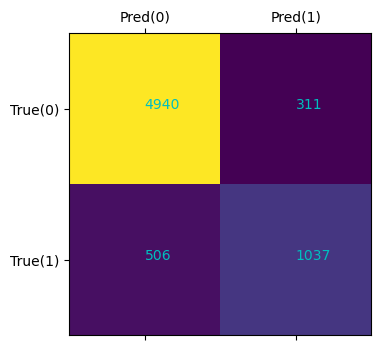

In [11]:
from sklearn.metrics import confusion_matrix

print(f"We have {y_test[y_test==0].shape[0]} non-bJect events \
and {y_test[y_test==1].shape[0]} bJet events.")

fig, ax = plt.subplots(1, figsize=(4, 4), dpi=100,
                       subplot_kw={'xticklabels': ['', 'Pred(0)', 'Pred(1)', ''], 
                                   'yticklabels': ['', 'True(0)', 'True(1)', '']})
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
axes = ax.matshow(cm, origin='upper')
coords_all = [[0, 0], [1, 0], [0, 1], [1, 1]]
for num, coords in zip(cm.flatten(), coords_all):
    ax.annotate(f"{num}", coords, xycoords='data', color='c')
plt.show()

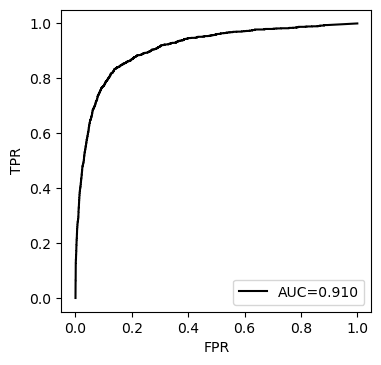

In [12]:
from sklearn.metrics import roc_curve, auc

y_proba = knn_clf.predict_proba(X_test_kpca)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])

fig, ax = plt.subplots(1, figsize=(4, 4), dpi=100,
                       subplot_kw={'xlabel': 'FPR', 
                                   'ylabel': 'TPR'})
ax.plot(fpr, tpr, 'k-', label=f'AUC={auc(fpr, tpr):.3f}')
ax.legend()
plt.show()

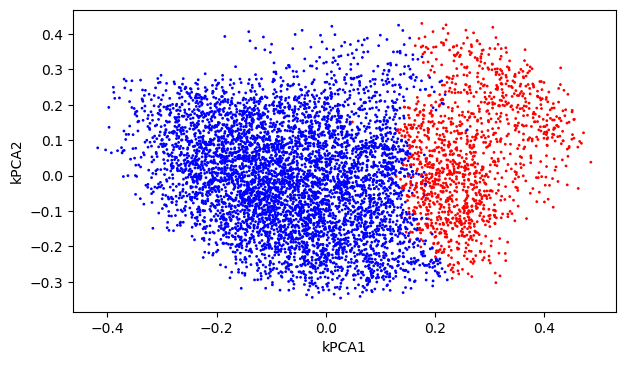

In [13]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'kPCA1', 
                                   'ylabel': 'kPCA2'})
plt.scatter(X_test_kpca[:,0], X_test_kpca[:,1], s=1, 
            c=y_pred, cmap='bwr')
plt.show()

# k-Means Clustering

We start by finding an optimal number of clusters $k$. Remember, k-MC is unsupervised, so we cannot check the accuracy in a real life use case, we can only use some algorithm metrics to judge its performance. (but here we do have the labels, so we can calculate the accuracy in the end)

First, we can start by using inertia as our measure of how well the $k$ clusters are defined (see `NeighboursAndCluster.ipynb` for the definition of inertia).

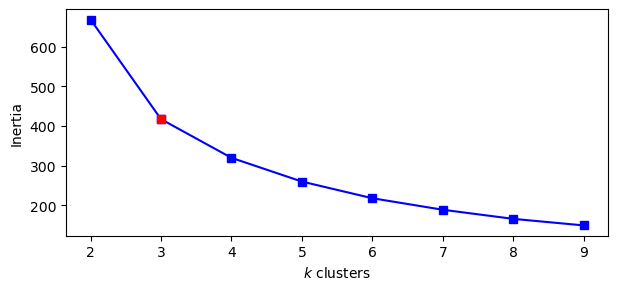

In [14]:
from sklearn.cluster import KMeans

# loop over several k values and record inertias
ks = np.arange(2, 10)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train_kpca)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
plt.plot(3, inertias[1], 'rs')
plt.show()

From the above, it seems that $k=3$ corresponds to the curve "elbow", after which the rate of improvement on the inertia becomes either constant or drops significantly, which suggests that we are not improving the clustering significantly, but rather overfitting too many clusters to our data.

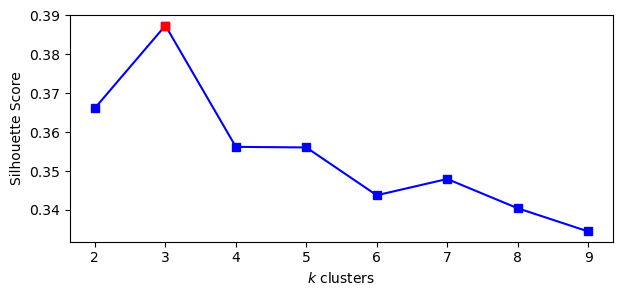

In [15]:
from sklearn.metrics import silhouette_score

ks = np.arange(2, 10)
scores = []
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train_kpca)
    scores.append(silhouette_score(X_train_kpca, kmeans.labels_))

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Silhouette Score'})
plt.plot(ks, scores, 'bs-')
plt.plot(3, scores[1], 'rs')
plt.show()

The silhouette metric suggests that $k=3$ and $k=2$ are the 1st and 2nd best options. As this method is a better test of $k$, we would choose the number of clusters based on it (i.e., $k=3$). However, we know that the ground truth is $k=2$. As we will see below, we cannot properly cluster these data, as we need different preprocessing techniques to transform the data into better defined clusters.

We can now use the model configuration with our test data, because we have the labels.

In [16]:
kmeans = KMeans(n_clusters=2, init='k-means++', 
                n_init=10, random_state=42)
kmeans.fit(X_train_kpca)
y_pred = kmeans.predict(X_test_kpca)

test_score = accuracy_score(y_test, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.227


We have 5251 non-bJect events and 1543 bJet events.


/Users/Vadim/miniconda3/envs/mlbd/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


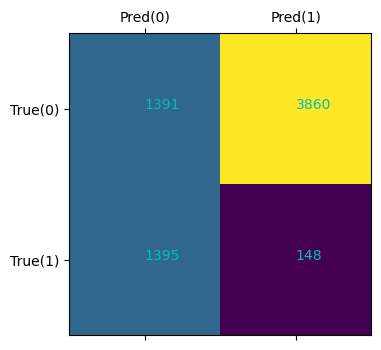

In [17]:
print(f"We have {y_test[y_test==0].shape[0]} non-bJect events \
and {y_test[y_test==1].shape[0]} bJet events.")

fig, ax = plt.subplots(1, figsize=(4, 4), dpi=100,
                       subplot_kw={'xticklabels': ['', 'Pred(0)', 'Pred(1)', ''], 
                                   'yticklabels': ['', 'True(0)', 'True(1)', '']})
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
axes = ax.matshow(cm, origin='upper')
coords_all = [[0, 0], [1, 0], [0, 1], [1, 1]]
for num, coords in zip(cm.flatten(), coords_all):
    ax.annotate(f"{num}", coords, xycoords='data', color='c')
plt.show()

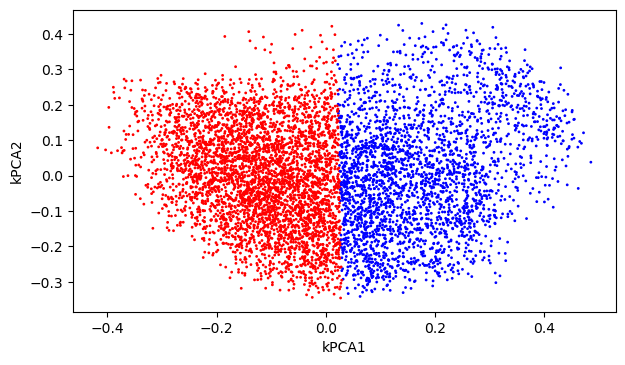

In [18]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'kPCA1', 
                                   'ylabel': 'kPCA2'})
plt.scatter(X_test_kpca[:,0], X_test_kpca[:,1], s=1, 
            c=y_pred, cmap='bwr')
plt.show()

Accuracy is only $\sim 23\%$ (even worse than a random guess). The issue is in using k-MC with the data that we have. k-MC works best with well-defined clusters; however, in Week 1 you saw that two classes (0 and 1) in the Aleph data set may not form well-shaped clusters. It doesn't mean we cannot use k-MC here, but rather that we need data preprocessing such that would allow for better clustering.

PCA, kPCA or similar dimensionality reduction techniques may not be sufficient and we may need feature importance ranking as well. **Try: (a) reducing dimensions to more than 2; (b) not reducing dimensions and using either the full or partial data set. Can you get a better result?**

Later, in Week 3 and 4 you we will start to use feature importance ranking (eg., SHAP values) and methods for manifold-learning (eg., t-SNE), which may be applied for preprocessing in this case.